# Spotify Feature Analytics

# Motivation

This project focuses on Spotify artists. We wanted to find the "Kevin Bacon number" equivalent for Spotify artists that worked together i.e. were featured on the same song. 

For this project, we used two datasets: edges.csv and nodes.csv. Edges.csv contains data on artists that are featured on the same song, it is in the form of an edge list of artist ids. Nodes.csv contains data on the Spotify artists, their id, name, etc.

We then used BFS to analyze the shortest path i.e. the number of connections between different artists.

# Imports and Setup

In [2]:
# import packages
import glob
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from collections import deque
from graphviz import Graph 



### Data Loading and Preprocessing

Download the CSV files: 
*   edges.csv: https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?select=edges.csv
*   nodes.csv: https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?select=nodes.csv

Drag them into Google Colab:
*   Expand menu on the left
*   Click file icon, the bottom-most icon
*   Click upload icon, the left-most icon
*   Upload the nodes.csv and edges.csv files

## Edges Data

This is the dataset containing data on the artists that are featured on the same song, it is in the form of an edge list of artist ids.

In [3]:
# load data
edges_df = pd.read_csv("edges.csv")

In [4]:
# preview data
edges_df.head()

,id_0,id_1
0,76M2Ekj8bG8W7X2nbx2CpF,7sfl4Xt5KmfyDs2T3SVSMK
1,0hk4xVujcyOr6USD95wcWb,7Do8se3ZoaVqUt3woqqSrD
2,38jpuy3yt3QIxQ8Fn1HTeJ,4csQIMQm6vI2A2SCVDuM2z
3,6PvcxssrQ0QaJVaBWHD07l,6UCQYrcJ6wab6gnQ89OJFh
4,2R1QrQqWuw3IjoP5dXRFjt,4mk1ScvOUkuQzzCZpT6bc0


## Nodes Data

This is the dataset containing data on the Spotify artists, their id, name, etc. 

In [5]:
# load data
nodes_df = pd.read_csv("nodes.csv")

# drop columns 
nodes_2_df = nodes_df[['spotify_id', 'name']]

In [6]:
# preview data
nodes_2_df.head()

,spotify_id,name
0,48WvrUGoijadXXCsGocwM4,Byklubben
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K
2,652XIvIBNGg3C0KIGEJWit,Maxim
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman


## Merge Nodes and Edges Data

We merge nodes_df and edges_df to get a dataset composed of an edge list of artists that are featured on the same song, but instead of by id it is by name.

In [7]:
# merge nodes_df and edges_df
feature_df = edges_df.merge(nodes_2_df, left_on = 'id_0', right_on = 'spotify_id')

# drop and rename columns
feature_2_df = feature_df[['name', 'id_1']]
feature_3_df = feature_2_df.rename(columns = {'name' : 'artist_1'})

# merge nodes_df and edges_df
feature_4_df = feature_3_df.merge(nodes_2_df, left_on = 'id_1', right_on = 'spotify_id')

# drop and rename columns
feature_5_df = feature_4_df[['artist_1', 'name']]
feature_6_df = feature_5_df.rename(columns = {'name' : 'artist_2'})

In [8]:
# preview data
feature_6_df.head()

,artist_1,artist_2
0,NGHTMRE,Lil Jon
1,Offset,Lil Jon
2,Max Styler,Lil Jon
3,Sak Noel,Lil Jon
4,Alvaro,Lil Jon


## Pandas Datafram to Numpy Array

In [9]:
# pandas dataframe to numpy array
feature_edge_list = feature_6_df.to_numpy()

In [10]:
# preview numpy array
feature_edge_list

array([['NGHTMRE', 'Lil Jon'],
       ['Offset', 'Lil Jon'],
       ['Max Styler', 'Lil Jon'],
       ...,
       ['Erdzan Saidov', 'Cubita'],
       ['Elai', 'Ayoo ELAI'],
       ['Def Rock', 'Tarlan']], dtype=object)

# Kevin Bacon Number Algorithm

## Adjacency List 

From the above feature_edge_list, we now create an adjacency list called spotify_adj_list. This is essentially the data structure that represents the graph of the artists network

In [11]:
def create_adj_list(edges):
  adj_list = {}
  for edge in edges:
    src, dest = edge
    if src not in adj_list:
      adj_list[src] = []
    if dest not in adj_list:
      adj_list[dest] = []
    adj_list[src].append(dest)
    adj_list[dest].append(src)
  return adj_list

In [12]:
spotify_adj_list = create_adj_list(feature_edge_list)


With the adjacency list, we can examine the direct neighbors (i.e. Kevvin Bacon Number with value 1). For example, the neighbors of 'Lil Jon' can be expected using the code below.

In [13]:
print(spotify_adj_list['Lil Jon'])

['NGHTMRE', 'Offset', 'Max Styler', 'Sak Noel', 'Alvaro', 'Laidback Luke', 'Dimitri Vegas & Like Mike', 'Freaky Bass', 'Gucci Mane', 'Pitbull', 'David Guetta', 'French Montana', 'Big Boi', 'Project Pat', '2 Chainz', 'Ludacris', 'Fat Joe', 'DJ Snake', 'Juan Magán', 'Becky G', 'Yandel', 'Travis Barker', 'Diplo', 'Waka Flocka Flame', 'Chris Brown', 'Mario', 'Big Ali', 'KD One', 'The-Dream', 'The Game', 'Hardwell', 'Daddy Yankee', 'Swizz Beatz', 'R. Kelly', 'LMFAO', 'Sidney Samson', 'DJ Drama', 'Stafford Brothers', 'Tyga', 'T-Pain', 'Kanye West', '3OH!3', 'Flo Rida', 'Eden xo', 'Usher', 'T.I.', 'Jay Sean', 'Machine Gun Kelly', 'Three 6 Mafia', 'W&W', 'Valentino Khan', 'Chuck Dem Gee', 'Outkast', 'Machel Montano', 'Mike Candys', 'Konshens', 'Juicy J', 'Ice Cube', 'Too $hort', 'Damian Marley', 'Jeezy', 'Play-N-Skillz', 'Borgeous', 'E-40', 'Duke Deuce', 'Far East Movement', 'Travis Porter', 'Marnik', 'Salvi', 'Jazze Pha', 'Ciara', 'Pastor Troy', 'Steve Aoki', 'MAKJ', 'Snoop Dogg', 'Ralvero', 

## BFS Algorithm

We will now use BFS for finding "Kevin Bacon Number" between two artists. First, we calculate the bacon number of all artists with respect to a single artist.

Function find_kevin_bacon takes in an artist as an input, and stores the kevin_bacon_distance of all artists that has a path in the graph. It also takes in the limit variable, which represents the maximum bacon distance it wishes to find. This variable is needed because of RAM and Disk constraint of google colab.

We will first store a global dictionary named `kevin_bacon_dict` that contains the artists with their respective distances from the input artist. The algorithm takes in an artist and a limit, and stores in `kevin_bacon_dict[artist]` a list of all artists within a distance of `limit`. 

In [14]:
kevin_bacon_dict = {}

def find_kevin_bacon(artist, limit):
  # Initialize the queue and visited set
    queue = deque([(artist, 0)])
    visited = set()
    visited.add(artist)

    kevin_bacon_dict[artist] = {}

    while queue:
      co_artist, bacon_number = queue.popleft()

      if bacon_number > limit:
        continue

      kevin_bacon_dict[artist][co_artist] = bacon_number
      
      for co_co_artist in spotify_adj_list[co_artist]:
        if co_co_artist not in visited:
          visited.add(co_co_artist)
          queue.append((co_co_artist, bacon_number + 1))

    return -1


# Find artists with kevin bacon number up to 3 for artist Lil Jon
find_kevin_bacon('Lil Jon', 3)

print(kevin_bacon_dict['Lil Jon'])

{'Lil Jon': 0, 'NGHTMRE': 1, 'Offset': 1, 'Max Styler': 1, 'Sak Noel': 1, 'Alvaro': 1, 'Laidback Luke': 1, 'Dimitri Vegas & Like Mike': 1, 'Freaky Bass': 1, 'Gucci Mane': 1, 'Pitbull': 1, 'David Guetta': 1, 'French Montana': 1, 'Big Boi': 1, 'Project Pat': 1, '2 Chainz': 1, 'Ludacris': 1, 'Fat Joe': 1, 'DJ Snake': 1, 'Juan Magán': 1, 'Becky G': 1, 'Yandel': 1, 'Travis Barker': 1, 'Diplo': 1, 'Waka Flocka Flame': 1, 'Chris Brown': 1, 'Mario': 1, 'Big Ali': 1, 'KD One': 1, 'The-Dream': 1, 'The Game': 1, 'Hardwell': 1, 'Daddy Yankee': 1, 'Swizz Beatz': 1, 'R. Kelly': 1, 'LMFAO': 1, 'Sidney Samson': 1, 'DJ Drama': 1, 'Stafford Brothers': 1, 'Tyga': 1, 'T-Pain': 1, 'Kanye West': 1, '3OH!3': 1, 'Flo Rida': 1, 'Eden xo': 1, 'Usher': 1, 'T.I.': 1, 'Jay Sean': 1, 'Machine Gun Kelly': 1, 'Three 6 Mafia': 1, 'W&W': 1, 'Valentino Khan': 1, 'Chuck Dem Gee': 1, 'Outkast': 1, 'Machel Montano': 1, 'Mike Candys': 1, 'Konshens': 1, 'Juicy J': 1, 'Ice Cube': 1, 'Too $hort': 1, 'Damian Marley': 1, 'Jeezy'

Here are the function for finding kevin bacon number with less than 4. Given two artists, if they have the bacon number less than 4, it will return the bacon number, and otherwise will return -1.

In [15]:
def find_spotify_kevin_bacon_less_than_4(artist1, artist2):
  find_kevin_bacon(artist1, 4)
  if artist2 in kevin_bacon_dict[artist1]:
    return kevin_bacon_dict[artist1][artist2]
  else:
    return -1


In [16]:
# Find kevin bacon number between Lil Jon and Offset
find_spotify_kevin_bacon_less_than_4('Lil Jon', 'Offset')


1

In [17]:
# Find kevin bacon number between Lil Jon and Cubita
find_spotify_kevin_bacon_less_than_4('Lil Jon', 'Cubita')


4

If you would like to check some values yourself, you can implement the function 

```
find_bacon_num_within_limit(artist1, artist2, limit)
```



In [18]:
def find_bacon_num_within_limit(artist1, artist2, limit):
  find_kevin_bacon(artist1, limit)
  if artist2 in kevin_bacon_dict[artist1]:
    return kevin_bacon_dict[artist1][artist2]
  else:
    return -1

In [19]:
# Find kevin bacon number between Drake and Kanye West
find_bacon_num_within_limit('Drake', 'Kanye West', 10)

1

# Experiment

**Question:** How many features away is the average artist from Pitbull?


The percentage of artists within a maximum distance of 8 is 97.23848494386738
The percentage of artists within a maximum distance of 15 is 97.28674850487882


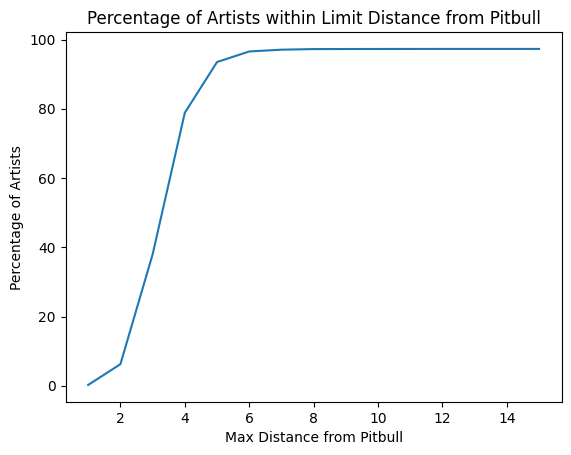

In [20]:
#Graph that visualizes the rate at which the number of artists increases as the limit increases
x = []
numberOfNodes = []
for i in range(1, 16):
  x.append(i)
  find_kevin_bacon('Pitbull', i)
  numberOfNodes.append(100 * len(kevin_bacon_dict['Pitbull']) / (len(spotify_adj_list)))
print("The percentage of artists within a maximum distance of 8 is " + str(numberOfNodes[7]))
print("The percentage of artists within a maximum distance of 15 is " + str(numberOfNodes[14]))
plt.plot(x, numberOfNodes, label= 'Pitbull')
plt.xlabel('Max Distance from Pitbull')
plt.ylabel('Percentage of Artists')
plt.title('Percentage of Artists within Limit Distance from Pitbull')
plt.show()

The mean distance from Pitbull of all the artists as the limit distance gets larger approaches 3.7829112922939765


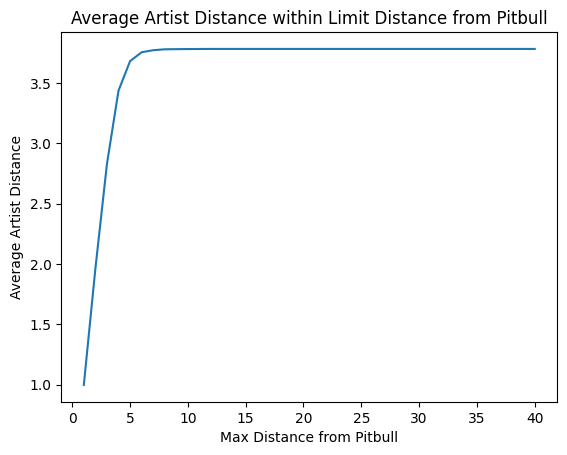

In [22]:
#Graph that shows the average distance from Pitbull of all artists as limit increases
x = []
avgDistance = []
for i in range(1, 41):
  sum = 0
  x.append(i)
  find_kevin_bacon('Pitbull', i)
  for node in kevin_bacon_dict['Pitbull']:
    sum += kevin_bacon_dict['Pitbull'][node]
  sum /= len(kevin_bacon_dict['Pitbull'])
  avgDistance.append(sum)
print('The mean distance from Pitbull of all the artists as the limit distance gets larger approaches ' + str(avgDistance[-1]))
plt.plot(x, avgDistance, label= 'Pitbull')
plt.xlabel('Max Distance from Pitbull')
plt.ylabel('Average Artist Distance')
plt.title('Average Artist Distance within Limit Distance from Pitbull')
plt.show()

**Data Analysis:** From our first graph, we see that the total number of artists within the limit distance plateus after around 8. That is, after a distance of 8, the rate at which people get added is very marginal. This demonstrates that the vast majority of people are within a distance of 8 from Pitbull. In our second graph, we see that the average artist distance from Pitbull approaches 3.78 as the limiting distance gets larger and larger. After over 97% of the artists are considered, we have an average artist distance of 3.78, even when our limiting distance is 40.

**Conclusion:** We get from the data that the average distance from an artist to Pitbull, within an upper limit of 40, is roughly 4.